## Australian Electricity Demand

This project aims to analyse some Australian electricity demand data generated from 2015-2020

### Opening and Exploring the Data
Let's start by opening two given data sets
1. Yearly Demand
The dataset includes 5 CSV files of actual Queensland electricity demand for the financial years
2015 to 2019. These files were downloaded from the AEMO website. Each file contains a row
for each day in the year and 48 columns for each half-hourly time interval from midnight.
2. Daily Demand
Recent daily actuals may be downloaded from the AEMO Data Portal:
https://aemo.com.au/en/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregateddata

### Opening Daily Demand Data

I have downloaded daily demand files from 2015-2020

                    REGION  TOTALDEMAND    RRP PERIODTYPE
date                                                     
2015-01-01 00:30:00   QLD1      6062.18  45.85      TRADE
2015-01-01 01:00:00   QLD1      5953.53  44.65      TRADE
2015-01-01 01:30:00   QLD1      5784.95  34.24      TRADE
2015-01-01 02:00:00   QLD1      5640.20  31.91      TRADE
2015-01-01 02:30:00   QLD1      5562.55  29.95      TRADE


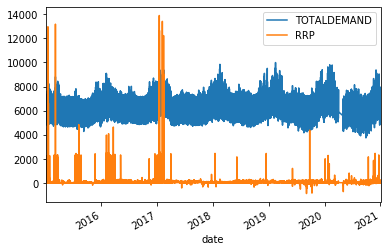

In [8]:
#load daily dataset which has half hourly data
import pandas as pd
import glob
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

path = r'./Daily' # use your path
all_files = glob.glob(path + "/*.csv") #Return a list of .csv files when file path is given
li = []

for filename in all_files:
    df = pd.read_csv(filename, parse_dates={'date':['SETTLEMENTDATE']}, index_col='date',squeeze=True) # reading each data file 
    li.append(df)

    
df = pd.concat(li, axis=0)# creating a dataframe concateniting all the downlaoded files
# summarize first few rows
print(df.head())
# line plot
df.plot()
pyplot.show()


We are only looking at total electricity demand in this project. Therefore We can get rid of other unnecessary columns for our analysis.


In [11]:
df.shape # number of data rows and columns before delete columns
df = df.drop('RRP', 1)
df = df.drop('PERIODTYPE', 1)
df = df.drop('REGION',1)

In [12]:
df.shape #let's look at the data frame size after deleting rows and columns

(105216, 1)

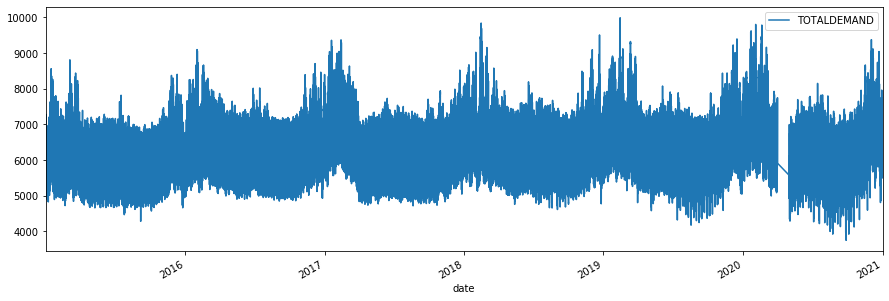

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D09248EC8>]],
      dtype=object)

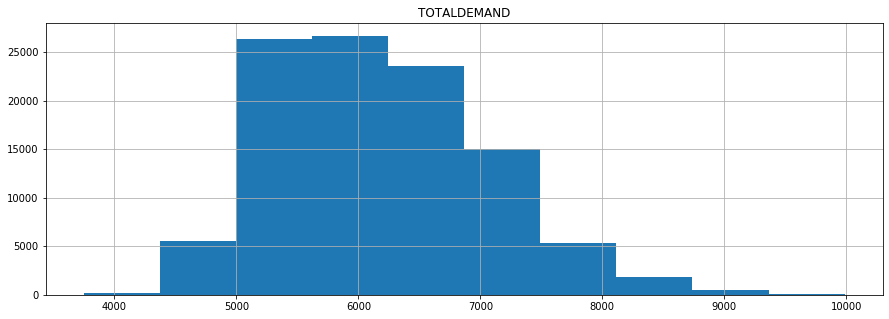

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = [15, 5] #set the figure size
df.plot()
plt.show()
df.hist()



### Basic Feature Engineering
 Let's do some basic feature engineering.
 


In [14]:
from pandas import DataFrame
from pandas import concat

df_vals = DataFrame(df.values)
shifted = df_vals.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
dataframe = concat([means, df_vals], axis=1)
dataframe.columns = ['mean(t-1,t)', 't+1']

print(dataframe.head(5))

   mean(t-1,t)      t+1
0          NaN  6062.18
1          NaN  5953.53
2     6007.855  5784.95
3     5869.240  5640.20
4     5712.575  5562.55


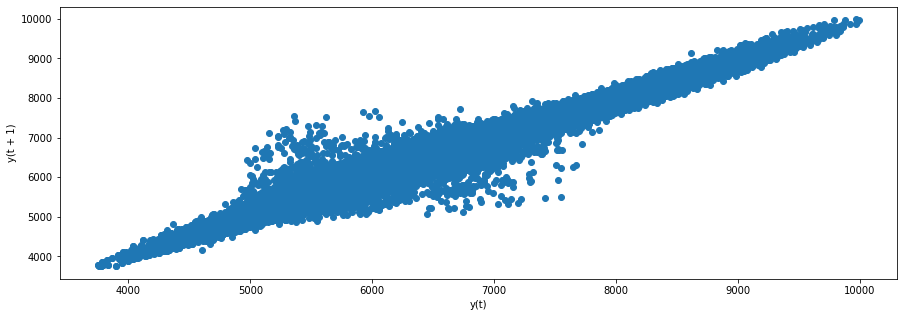

In [15]:
#lag plot confirms the time series data
from pandas.plotting import lag_plot
lag_plot(dataframe)

### Is time series stationary?

Dickey-Fuller test is one of the statistical tests for checking stationarity. Here the null hypothesis is that thetime series is non-stationary.


In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(df)

### ARIMA

C:\Users\Dilesha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Dilesha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.TOTALDEMAND   No. Observations:               105215
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -662225.679
Method:                       css-mle   S.D. of innovations            130.985
Date:                Tue, 02 Mar 2021   AIC                        1324465.358
Time:                        08:27:19   BIC                        1324532.304
Sample:                             1   HQIC                       1324485.628
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0011      1.196      0.001      0.999      -2.343       2.346
ar.L1.D.TOTALDEMAND     0.3511      0.003    114.466      0.000       0.345       0.357
ar.L2.D.TOTALDEM

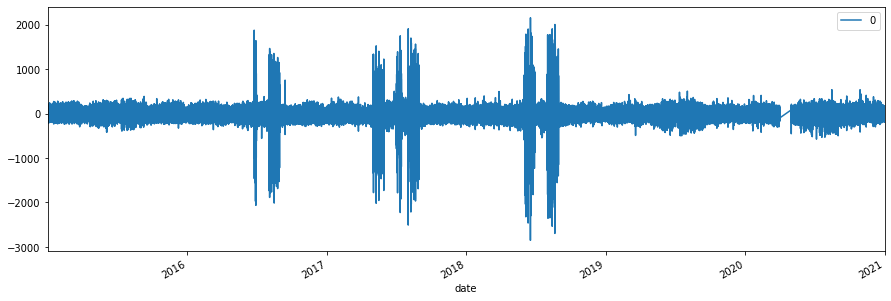

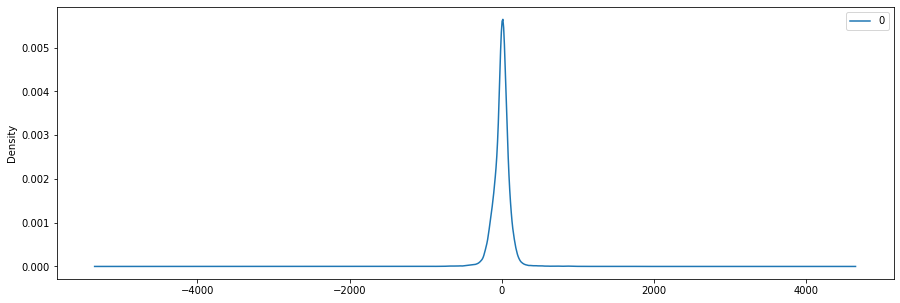

                   0
count  105215.000000
mean       -0.001356
std       130.985731
min     -2850.947930
25%       -48.871987
50%         7.105268
75%        54.119125
max      2153.797962


In [27]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# fit model
model = ARIMA(df, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [21]:
print(df.head())

                     TOTALDEMAND
date                            
2015-01-01 00:30:00      6062.18
2015-01-01 01:00:00      5953.53
2015-01-01 01:30:00      5784.95
2015-01-01 02:00:00      5640.20
2015-01-01 02:30:00      5562.55


### Forecasting using ARIMA


In [26]:
# split into train and test sets
X = df.values
size = int(len(X) * 0.9)
datestest =df[size:len(df)]
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print(datestest[t])       
    print(datestest.index[t],end =" ") 
    print('predicted=%f, expected=%f' % (yhat, obs))
            
file.close()            
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()




2020-05-26 19:30:00 predicted=7284.652701, expected=7080.340000
2020-05-26 20:00:00 predicted=6992.417661, expected=6981.210000
2020-05-26 20:30:00 predicted=6868.979336, expected=6853.030000
2020-05-26 21:00:00 predicted=6760.661405, expected=6675.250000
2020-05-26 21:30:00 predicted=6566.595378, expected=6459.080000
2020-05-26 22:00:00 predicted=6338.584603, expected=6318.990000
2020-05-26 22:30:00 predicted=6197.451446, expected=6232.100000
2020-05-26 23:00:00 predicted=6146.616342, expected=6047.490000
2020-05-26 23:30:00 predicted=5958.029592, expected=5842.040000
2020-05-27 00:00:00 predicted=5728.893548, expected=5628.250000
2020-05-27 00:30:00 predicted=5490.710187, expected=5494.850000
2020-05-27 01:00:00 predicted=5370.335002, expected=5332.390000
2020-05-27 01:30:00 predicted=5229.401132, expected=5235.890000
2020-05-27 02:00:00 predicted=5155.512566, expected=5168.630000
2020-05-27 02:30:00 predicted=5116.874315, expected=5130.810000
2020-05-27 03:00:00 predicted=5095.87100

KeyboardInterrupt: 